# Data Preprocessing TEST: MODIS Cloud Mask
1. Grab 2 Co-located MODIS and CloudSatCalipso Swaths
2. Import longitude, latitude, and Cloud Mask for each file
3. Filter lat/lons that are not within the acceptable threshold (MODIS & CC are less than 0.025 degrees apart)
4. Concatenate data into one array

In [1]:
from pyhdf.SD import SD, SDC
from pyhdf.HDF import HDF, HC
from pyhdf.VS import *
import os
import numpy as np

filenameCC = os.path.join("CloudSatCALIPSO","2007001023034_03608_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E02_F00.hdf")
filenameMOD = os.path.join("MODIS_cloudMask","MAC35S0.A2007001.0405.002.2017117214811.hdf")

## CloudSat Calipso hdf4 to Numpy Array
1. Open File using pyhdf's Vdata
2. Read Latitude, Longitude, and Cloudlayer arrays
3. Close file

In [2]:
# Open HDF
hdf_file = HDF(filenameCC, HC.READ)

# Open Vdata interface
vdata = hdf_file.vstart()

# Get list of Vdata fields
vdata_info = vdata.vdatainfo()

# Iterate through Vdata fields
for index, info in enumerate(vdata_info):
    try:
        field_name = info[0]
        print("Field Name:", field_name)
        
        # Check if the Vdata field contains data
        if field_name == 'Latitude':
            field_ref = vdata.attach(field_name)
            latitude_data_cc = field_ref[:]
            field_ref.detach()
        elif field_name == 'Longitude':
            field_ref = vdata.attach(field_name)
            longitude_data_cc = field_ref[:]
            field_ref.detach()
        elif field_name == 'Cloudlayer':
            field_ref = vdata.attach(field_name)
            cloud_layer = field_ref[:]
            field_ref.detach()
        
    except HDF4Error as e:
        print(f"Error attaching Vdata field at index {index}: {e}")

# Close Vdata interface
vdata.end()

# Close HDF
hdf_file.close()

Field Name: Profile_time
Field Name: UTC_start
Field Name: TAI_start
Field Name: Latitude
Field Name: Longitude
Field Name: Range_to_intercept
Field Name: DEM_elevation
Field Name: Vertical_binsize
Field Name: Pitch_offset
Field Name: Roll_offset
Field Name: Data_quality
Field Name: Data_status
Field Name: Data_targetID
Field Name: RayStatus_validity
Field Name: Navigation_land_sea_flag
Field Name: Cloudlayer
Field Name: nray:2B-CLDCLASS-LIDAR
Field Name: nbin:2B-CLDCLASS-LIDAR
Field Name: ncloud:2B-CLDCLASS-LIDAR


Sanity Check

In [3]:
print(np.shape(longitude_data_cc))
print(np.shape(latitude_data_cc))

(37081, 1)
(37081, 1)


## MODIS hdf4 to Numpy Array
1. Open File using pyhdf's Scientific Dataset reader (SD)
2. Read Latitude, Longitude, and Cloud_Mask arrays
3. Close file

In [4]:
# Open HDF
hdf_file = SD(filenameMOD, SDC.READ)

# List SDS datasets
sds_datasets = hdf_file.datasets()

# Iterate through SDS datasets
for dataset_name in sds_datasets:
    
    print("SD dataset name:", dataset_name)
    if 'Latitude' in dataset_name:
        latitude_data_mod = hdf_file.select(dataset_name)[:]
    elif 'Longitude' in dataset_name:
        longitude_data_mod = hdf_file.select(dataset_name)[:]
    elif 'Cloud_Mask' == dataset_name:
        data = hdf_file.select(dataset_name)
        dataarray = data[:]
        dataarray = dataarray[0,:,5]
        
        # Get dataset attributes
        attrs = data.attributes()
        for attr_name in attrs.keys():
            if 'description' == attr_name:
                print("Attribute:", attr_name)
                print("Value:", attrs[attr_name])

        # Gather data as Bytes
        binary_data = [format(byte & 0xFF, '08b') for byte in dataarray]
        # Gather 2nd and 3rd bit from right
        extracted_bits = [byte[-4:-2] for byte in binary_data]
        # Cloud mask information, simplify to [1,0]
        cloud_mask_mod = [1 if bits in ['00', '01'] else 0 for bits in extracted_bits]
        
# Close HDF
hdf_file.end()
print(np.shape(cloud_mask_mod))

SD dataset name: Latitude
SD dataset name: Longitude
SD dataset name: Scan_Start_Time
SD dataset name: Solar_Zenith
SD dataset name: Solar_Azimuth
SD dataset name: Sensor_Zenith
SD dataset name: Sensor_Azimuth
SD dataset name: Cloud_Mask_SPI
SD dataset name: Cloud_Mask
Attribute: description
Value: \n                                                                                  
                                                                                    
 Bit fields within each byte are numbered from the left:                            
 7, 6, 5, 4, 3, 2, 1, 0.                                                            
 The left-most bit (bit 7) is the most significant bit.                             
 The right-most bit (bit 0) is the least significant bit.                           
                                                                                    
 bit field       Description                             Key                        
 ---------       ---

Sanity Checks

In [5]:
print(np.shape(longitude_data_cc))
print(np.shape(latitude_data_cc))

(37081, 1)
(37081, 1)


In [6]:
print(dataarray[1000])
print(binary_data[1000])
print(extracted_bits[1000])
print(cloud_mask_mod[1000])
print(dataarray[2000])
print(binary_data[2000])
print(extracted_bits[2000])
print(cloud_mask_mod[2000])

49
00110001
01
1
-15
11110001
11
0


Flatten Arrays, MODIS data is [406,3]. The 3 represents width, with the left and right representing 5km from the cloudsat/calipso reading. The middle is what we want, as it is closest to cloudsat/calipso

In [7]:
longitude_data_mod = np.ravel(longitude_data_mod[:,1])
latitude_data_mod = np.ravel(latitude_data_mod[:,1])
longitude_data_cc = np.ravel(longitude_data_cc)
latitude_data_cc = np.ravel(latitude_data_cc)

## Plot MODIS and Cloudsat Calipso readings on globe!
Shows Overlap

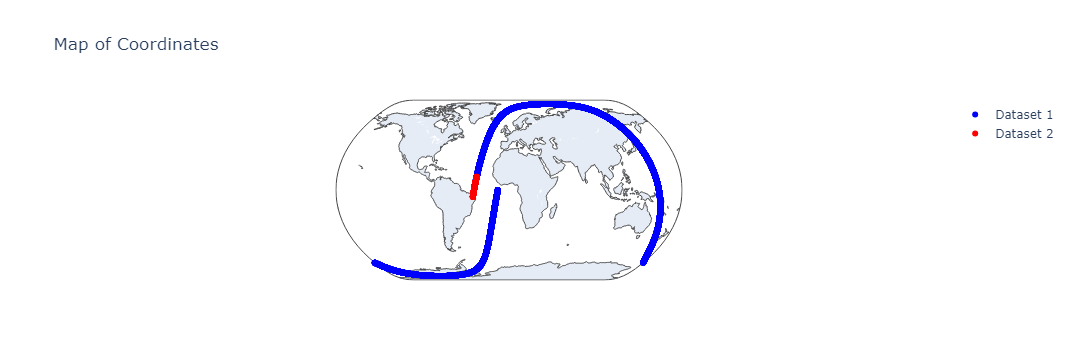

In [8]:
import numpy as np
import plotly.graph_objects as go

def plot_coordinates(lat1, lon1, lat2, lon2):
    fig = go.Figure()

    # Add scatter traces for dataset 1 and dataset 2
    fig.add_trace(go.Scattergeo(
        lat=lat1, lon=lon1,
        mode='markers',
        marker=dict(color='blue'),
        name='Dataset 1'
    ))

    fig.add_trace(go.Scattergeo(
        lat=lat2, lon=lon2,
        mode='markers',
        marker=dict(color='red'),
        name='Dataset 2'
    ))

    # Update layout
    fig.update_layout(
        title='Map of Coordinates',
        geo=dict(
            projection_type='natural earth'
        )
    )

    fig.show()


plot_coordinates(latitude_data_cc, longitude_data_cc, latitude_data_mod, longitude_data_mod)


## Use KDTree to quickly colocate CC and MODIS data

In [9]:
import numpy as np
from scipy.spatial import cKDTree
import pickle

def build_tree(lat, lon):
    return cKDTree(np.column_stack((lat, lon)))

def co_locate(tree, lat1, lon1, lat2, lon2, threshold):
    co_located_indices = []
    
    for i, (lat1, lon1) in enumerate(zip(lat2, lon2)):
        dist, idx = tree.query([lat1, lon1])
        if dist <= threshold:
            co_located_indices.append((idx, i))
            
    return co_located_indices

tree = build_tree(latitude_data_cc, longitude_data_cc)

co_located_indices = co_locate(tree, latitude_data_cc, longitude_data_cc, latitude_data_mod, longitude_data_mod, 0.025)
print(np.shape(co_located_indices))

(259, 2)


Flatten Arrays, Concatenate!

In [10]:
# Flatten Cloud Layer
cloud_layer = np.ravel(cloud_layer)
print(np.shape(cloud_layer))
print(np.sum(np.count_nonzero(cloud_layer)))

(37081,)
29363


In [11]:
# Locate points on cloud layer which line up with points from MODIS
cloud_layer_colocated = np.array([cloud_layer[idx[0]] for idx in co_located_indices])
cloud_layer_colocated = np.reshape(cloud_layer_colocated, (-1, 1))
print(np.shape(cloud_layer_colocated))
print(np.sum(np.count_nonzero(cloud_layer_colocated)))

(259, 1)
226


In [12]:
print(np.shape(cloud_mask_mod))

(2030,)


In [13]:
# Locate points on cloud mask which line up with points on CloudSat Calipso
cloud_mask_mod_colocated = [cloud_mask_mod[idx[1]] for idx in co_located_indices]
cloud_mask_mod_colocated = np.reshape(cloud_mask_mod_colocated, (-1, 1))
print(np.shape(cloud_mask_mod_colocated))
print(np.sum(np.count_nonzero(cloud_mask_mod_colocated)))

(259, 1)
259


In [14]:
# Join arrays
concatenated_array = np.concatenate((cloud_layer_colocated, cloud_mask_mod_colocated), axis=1)
print(np.shape(concatenated_array))

(259, 2)
